# 03 — Event Study: VIX Spikes

In this notebook we identify and analyze **major volatility spikes (VIX surges)** hand how real-world news events explain spikes in the VIX. We conduct research on market news and provide sources for an annotated VIX Market Events chart.

This section builds directly on the data collected in earlier notebooks.

**Objectives:**
- Detect and document major **VIX spike events** (extreme volatility episodes).  
- Annotate these events with real-world market or news explanations.  
- Visualize VIX behavior and corresponding S&P 500 drawdowns.  
- Quantify **equity return patterns before and after spikes**.

**Data Used:**
- `data/raw/vix_ytd_ohlc.csv`
- `data/raw/sp500_ytd_ohlcv.csv`
- `data/interim/vix_spike_annotations.csv`  
  *(contains event dates, % changes, S&P 500 returns, and source links).*

**Outputs:**
- Annotated event visualization (`reports/figures/vix_spikes_annotated.png`)
- Interim data file with annotations (`data/interim/vix_spike_annotations.csv`)
- Event-window cumulative return tables and plots

**Notes:**
- Event selection combines quantitative filtering (large VIX daily % jumps)  
  with qualitative context (news verification via Bloomberg, CNN, etc.).
- Visualization highlights key spikes with labeled boxes and arrows.  
- Example events:  
  - *Mar 10 — Tariff anxiety spooks markets*  
  - *Apr 02 — Liberation Day Tariffs*  
  - *Aug 01 — Tariff escalation and weak jobs report*  
  - *Oct 10 — Trump announces 130% tariffs on China*  
  - *Oct 16 — Jamie Dimon “cockroaches” comment on private credit*

**Default window:** 2025 YTD (Jan 02 – Nov 06 2025)  
Trading days considered = 213

**Imports, reads, and initial calculations**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

# folders
os.makedirs("../reports/figures", exist_ok=True)
os.makedirs("../data/interim", exist_ok=True)
os.makedirs("../data/processed", exist_ok=True)

# style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["lines.linewidth"] = 2

# data
vix_df = pd.read_csv("../data/raw/vix_ytd_ohlc.csv", parse_dates=["Date"]).sort_values("Date")
spx_df = pd.read_csv("../data/raw/sp500_ytd_ohlcv.csv", parse_dates=["Date"]).sort_values("Date")

# returns
vix_df["dVIX"] = vix_df["Close"].pct_change()
spx_df["dSPX"] = spx_df["Adj Close"].pct_change()

**Spike Detection**

In [ ]:
# Parameters
LEVEL_PCTL = 0.95        # spike if VIX >= 95th percentile
JUMP_SIGMA = 2.0         # spike if ΔVIX >= mean + 2*std
COOLDOWN_DAYS = 3        # merge spikes within ±3 trading days
TOP_N_FOR_ANNOT = 10      # how many to label on the big plot

# level-based
level_thresh = vix_df["Close"].quantile(LEVEL_PCTL)
level_spikes = vix_df[vix_df["Close"] >= level_thresh].copy()
level_spikes["reason"] = "level"

# jump-based
mu = vix_df["dVIX"].mean(skipna=True)
sd = vix_df["dVIX"].std(skipna=True)
jump_thresh = mu + JUMP_SIGMA*sd
jump_spikes = vix_df[vix_df["dVIX"] >= jump_thresh].copy()
jump_spikes["reason"] = "jump"

# union
spikes_raw = pd.concat([level_spikes, jump_spikes], ignore_index=True).sort_values("Date")

# de-duplicate within a cooldown window
dedup = []
for _, row in spikes_raw.iterrows():
    if not dedup:
        dedup.append(row)
    else:
        if (row["Date"] - dedup[-1]["Date"]).days <= COOLDOWN_DAYS:
            # keep the larger VIX close within the cluster
            if row["Close"] > dedup[-1]["Close"]:
                dedup[-1] = row
        else:
            dedup.append(row)

spikes = pd.DataFrame(dedup).reset_index(drop=True)

# enrich with same-day SPX return & VIX jump
spikes = spikes.merge(spx_df[["Date","dSPX"]], on="Date", how="left")
spikes["dVIX"] = vix_df.set_index("Date")["dVIX"].reindex(spikes["Date"]).values

print(f"Detected {len(spikes)} unique VIX spike days.")
spikes.head()

Detected 8 unique VIX spike days.


,Date,Open,High,Low,Close,dVIX,reason,dSPX
0,2025-01-27,18.83,22.51,17.57,17.90,0.205387,jump,-0.014581
1,2025-03-10,24.70,29.56,24.68,27.86,0.192127,jump,-0.026973
2,2025-04-08,44.04,57.52,36.48,52.33,0.113878,level,-0.015701
3,2025-04-16,33.24,34.96,29.48,32.64,0.083665,level,-0.022408
4,2025-04-21,32.75,35.75,31.79,33.82,0.140641,level,-0.023567


**Initial Date Annotations**

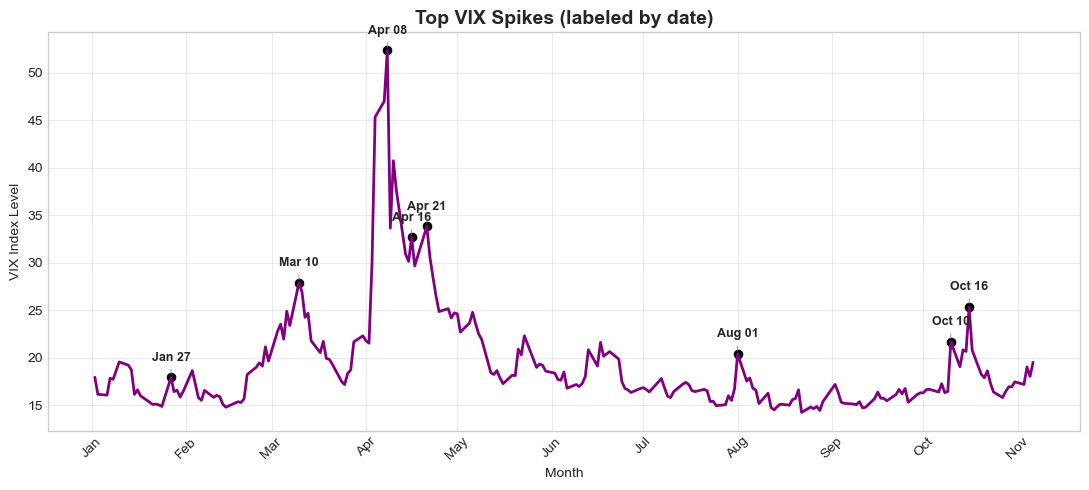

In [ ]:
# choose top N spikes by VIX level
topN = spikes.nlargest(TOP_N_FOR_ANNOT, "Close").sort_values("Date")

fig, ax = plt.subplots(figsize=(11,5))
ax.plot(vix_df["Date"], vix_df["Close"], color="purple")
ax.scatter(spikes["Date"], spikes["Close"], color="black", s=35)

year = vix_df["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=vix_df["Date"].max(), freq="MS")
ax.set_xticks(ticks); ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

for _, r in topN.iterrows():
    ax.annotate(
        r["Date"].strftime("%b %d"),
        xy=(r["Date"], r["Close"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center", fontsize=9, weight="bold",
        arrowprops=dict(arrowstyle="-", lw=0.5, color="gray")
    )

ax.set_title("Top VIX Spikes (labeled by date)", fontsize=14, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("VIX Index Level")
ax.grid(alpha=0.4)

plt.tight_layout()
plt.savefig("../reports/figures/vix_spikes_topN_labeled.png", dpi=300, bbox_inches="tight")
plt.show()

**Market Events/Research**

The relevant spikes and events are added into the csv file `vix_spike_annotations.csv`

The research and sources were found manually on the internet!

In [ ]:
## Create an annotations table to fill manually
## DONT RUN AGAIN SINCE IT OVERWRITES PREVIOUS EDITS ##

# annot_path = "../data/interim/vix_spike_annotations.csv"

## annot = pd.DataFrame({
##    "Date": spikes["Date"].dt.strftime("%Y-%m-%d"),
##    "VIX_Close": spikes["Close"].round(2),
##    "VIX_d1_pct": (spikes["dVIX"]*100).round(2),
##    "SPX_ret_pct": (spikes["dSPX"]*100).round(2),
##    "Event": "",     # <-- fill in
##    "Source": ""     # <-- short citation})

## annot.to_csv(annot_path, index=False)
## annot.head()

Open `data/interim/vix_spike_annotations.csv` and fill in Event and Source for each spike. Here are the edits I made:

Date,VIX_Close,VIX_d1_pct,SPX_ret_pct,Event,Source

2025-03-10,27.86,19.21,-2.7,"Tariff anxiety spooks markets","https://www.bloomberg.com/news/articles/2025-03-10/vix-nears-30-first-time-since-august-shock-on-tariff-anxiety"

2025-04-08,52.33,11.39,-1.57,"Post Liberation Day volatility spike","https://www.kitco.com/news/off-the-wire/2025-04-07/stocks-plunge-tariff-turmoil-vix-fear-gauge-spikes"

2025-08-01,20.38,21.89,-1.6,"Tariff escalation and weak jobs report","https://sweetvolatility.com/volatility-market-recap-july-28-august-2-2025"

2025-10-10,21.66,31.83,-2.71,"Trump announces 130% tariffs on China","https://www.cnn.com/2025/10/10/economy/trump-china-tariff-threats-economy"

2025-10-16,25.31,22.63,-0.63,"Jamie Dimon cockroaches comment on private credit market","https://www.cnn.com/2025/10/16/business/jamie-dimon-us-economy-cockroaches"

**Adding Liberation Day row** (record spike in data)

In [3]:
# Add Liberation Day Tariffs event
annot_path = "../data/interim/vix_spike_annotations.csv"
annot = pd.read_csv(annot_path, parse_dates=["Date"])

target_date = pd.Timestamp("2025-04-02")         # Liberation Day date

# get row for the date
vix_row = vix_df.loc[vix_df["Date"] == target_date].iloc[0]
spx_row = spx_df.loc[spx_df["Date"] == target_date].iloc[0]

new_row = pd.DataFrame({
    "Date": [target_date],
    "VIX_Close": [round(vix_row["Close"], 2)],
    "VIX_d1_pct": [round(vix_row["dVIX"] * 100, 2)],
    "SPX_ret_pct": [round(spx_row["dSPX"] * 100, 2)],
    "Event": ["Liberation Day Tariffs"],
    "Source": ["https://en.wikipedia.org/wiki/Liberation_Day_tariffs"]
})

# append
if not (annot["Date"] == target_date).any():
    annot = pd.concat([annot, new_row], ignore_index=True)
    annot = annot.sort_values("Date").reset_index(drop=True)
    annot.to_csv(annot_path, index=False)
    print("Added Liberation Day Tariffs row.")

annot

,Date,VIX_Close,VIX_d1_pct,SPX_ret_pct,Event,Source
0,2025-03-10,27.86,19.21,-2.70,Tariff anxiety spooks markets,https://www.bloomberg.com/news/articles/2025-0...
1,2025-04-02,21.51,-1.19,0.67,Liberation Day Tariffs,https://en.wikipedia.org/wiki/Liberation_Day_t...
2,2025-04-08,52.33,11.39,-1.57,Post Liberation Day volatility spike,https://www.kitco.com/news/off-the-wire/2025-0...
3,2025-08-01,20.38,21.89,-1.60,Tariff escalation and weak jobs report,https://sweetvolatility.com/volatility-market-...
4,2025-10-10,21.66,31.83,-2.71,Trump announces 130% tariffs on China,https://www.cnn.com/2025/10/10/economy/trump-c...
5,2025-10-16,25.31,22.63,-0.63,Jamie Dimon cockroaches comment on private cre...,https://www.cnn.com/2025/10/16/business/jamie-...


**Saving Results**

In [8]:
summary = spikes[["Date","Close","dVIX","dSPX"]].copy()
summary = summary.rename(columns={
    "Close":"VIX_Close",
    "dVIX":"VIX_d1",
    "dSPX":"SPX_ret"
})
summary["VIX_d1_pct"] = (summary["VIX_d1"]*100).round(2)
summary["SPX_ret_pct"] = (summary["SPX_ret"]*100).round(2)
summary = summary.drop(columns=["VIX_d1","SPX_ret"])
summary = summary.sort_values("Date").reset_index(drop=True)

summary_path = "../data/processed/event_study_summary.csv"
summary.to_csv(summary_path, index=False)
summary.head()

,Date,VIX_Close,VIX_d1_pct,SPX_ret_pct
0,2025-01-27,17.90,20.54,-1.46
1,2025-03-10,27.86,19.21,-2.70
2,2025-04-08,52.33,11.39,-1.57
3,2025-04-16,32.64,8.37,-2.24
4,2025-04-21,33.82,14.06,-2.36


**Annotated VIX plot with footnotes and caption**

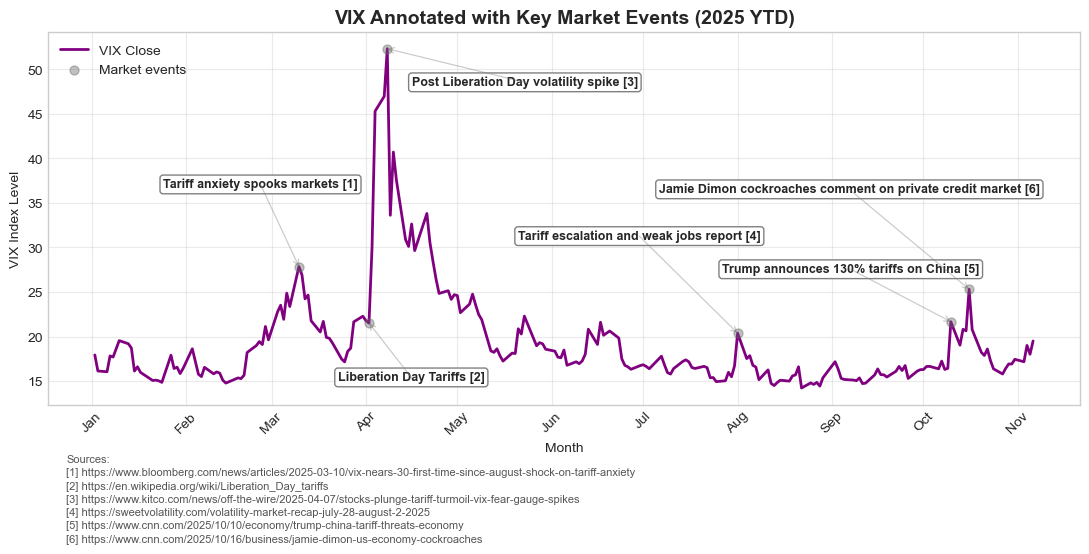

In [ ]:
# 1) keep only filled events
annot_events = pd.read_csv("../data/interim/vix_spike_annotations.csv", parse_dates=["Date"])
annot_events["Event"] = annot_events["Event"].astype(str).str.strip()
annot_events = annot_events[annot_events["Event"] != ""].copy()
annot_events = annot_events.sort_values("Date")

# 2) snap annotation dates to trading days in vix_df
vix_sorted = vix_df.sort_values("Date")[["Date","Close"]].rename(columns={"Close":"VIX_Close_plot"})
snapped = pd.merge_asof(
    annot_events[["Date","Event","Source"]].sort_values("Date"),
    vix_sorted.sort_values("Date"),
    on="Date",
    direction="backward",
    allow_exact_matches=True
).drop_duplicates(subset=["Date"], keep="first")

# FOOTNOTE NUMBERS
snapped["Source"] = snapped["Source"].astype(str).str.strip()
has_src = snapped["Source"].ne("") & snapped["Source"].ne("nan")
snapped["_footnum"] = 0
snapped.loc[has_src, "_footnum"] = range(1, int(has_src.sum()) + 1)
foot_map = dict(zip(snapped["Date"], snapped["_footnum"]))

# 3) plot base line + points
plt.close('all')
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(vix_df["Date"], vix_df["Close"], color="purple", linewidth=2, label="VIX Close")
ax.scatter(
    snapped["Date"], snapped["VIX_Close_plot"],
    color="#666666", s=42, zorder=5, alpha=0.4, label="Market events"
)

# month ticks
year = vix_df["Date"].min().year
ticks = pd.date_range(start=f"{year}-01-01", end=vix_df["Date"].max(), freq="MS")
ax.set_xticks(ticks)
ax.set_xticklabels(ticks.strftime("%b"), rotation=45)

# 4) labels
bbox = dict(boxstyle="round,pad=0.25", fc="white", ec="gray", alpha=1.0)
offsets = {
    "2025-03-10": (-15, 8),
    "2025-04-02": (-2, -7),
    "2025-04-08": (40, -5),
    "2025-08-01": (-10, 10),
    "2025-10-10": (-10, 5),
    "2025-10-16": (20, 10),
}

texts = []
for _, r in snapped.iterrows():
    date_str = r["Date"].strftime("%Y-%m-%d")
    dx, dy = offsets.get(date_str, (0, 6))
    fn = int(foot_map.get(r["Date"], 0))
    label = r["Event"] + (f" [{fn}]" if fn > 0 else "")
    texts.append(
        ax.annotate(
            label,
            xy=(r["Date"], r["VIX_Close_plot"]),
            xytext=(r["Date"] + pd.Timedelta(days=dx), r["VIX_Close_plot"] + dy),
            textcoords="data",
            ha="center", va="bottom",
            fontsize=9, weight="bold",
            bbox=bbox,
            zorder=3
        )
    )

adjust_text(
    texts, ax=ax,
    expand_points=(1.1, 1.3),
    expand_text=(1.05, 1.2),
    force_points=0.2,
    force_text=0.2,
    only_move={'points': 'y', 'texts': 'xy'}
)

# 5) Arrows
arrowprops = dict(
    arrowstyle="->",
    color="gray",
    lw=0.9,
    shrinkA=0,
    shrinkB=0,
    alpha=0.4,    # transparency for arrow lines
    zorder=2      # arrows below text
)

for text, (_, r) in zip(texts, snapped.iterrows()):
    ax.annotate(
        "",
        xy=(r["Date"], r["VIX_Close_plot"]),
        xytext=text.get_position(),
        textcoords='data',
        arrowprops=arrowprops
    )

# CAPTION
if has_src.any():
    src_rows = snapped.loc[has_src, ["_footnum", "Source"]].sort_values("_footnum")
    lines = [f"[{int(n)}] {s}" for n, s in zip(src_rows["_footnum"], src_rows["Source"])]
    caption = "Sources:\n" + "\n".join(lines)

    # axis box in figure coords
    x0, y0, _, _ = ax.get_position().bounds

    # push the caption left of the y-axis
    left_pad = 0.06   # increase to move further left; decrease to move right
    x_left = max(0.0, x0 - left_pad)

    fig.text(
        x_left, y0 - 0.03,     # coords
        caption,
        ha="left", va="top",
        fontsize=8,
        color="#555555",
        linespacing=1.4
    )

ax.set_title("VIX Annotated with Key Market Events (2025 YTD)", fontsize=14, weight="bold")
ax.set_xlabel("Month")
ax.set_ylabel("VIX Index Level")
ax.legend(loc="upper left", frameon=False)
ax.grid(alpha=0.4)

plt.tight_layout(rect=[0,0.05,1,1])
plt.savefig("../reports/figures/vix_spikes_annotated.png", dpi=300, bbox_inches="tight")
plt.show()